In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib



In [16]:
# 1) Load dataset
df = pd.read_csv("/content/train_u6lujuX_CVtuZ9i.csv")
print("Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()

# 2) Loan Status column handling
if "Loan_Status" in df.columns:
    df["Loan_Status"] = df["Loan_Status"].apply(lambda x: 1 if x == "Y" else 0)
elif "Loan Status" in df.columns:
    df["Loan Status"] = df["Loan Status"].apply(lambda x: 1 if x == "Y" else 0)
else:
    raise ValueError("No 'Loan_Status' or 'Loan Status' column found in dataset.")


Dataset loaded successfully!
Shape: (614, 13)


In [17]:
# 3) Convert categorical and boolean columns
# Drop ID if exists
if "id" in df.columns:
    df = df.drop(columns=["id"])

# Boolean-like columns
for c in ["fbs", "Education"]:
    if c in df.columns:
        df[c] = df[c].replace({"Graduate": 1, "Not Graduate": 0})

# Gender / Married
if "Gender" in df.columns:
    df["Gender"] = df["Gender"].replace({"Male": 1, "Female": 0, "M": 1, "F": 0})

if "Married" in df.columns:
    df["Married"] = df["Married"].replace({"Yes": 1, "No": 0})

if "Self_Employed" in df.columns:
    df["Self_Employed"] = df["Self_Employed"].replace({"Yes": 1, "No": 0})

# Replace missing indicators and convert to numeric if possible
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].replace("?", np.nan)
        try:
            df[c] = pd.to_numeric(df[c])
        except:
            pass

/tmp/ipython-input-46119362.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].replace({"Graduate": 1, "Not Graduate": 0})
/tmp/ipython-input-46119362.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Gender"] = df["Gender"].replace({"Male": 1, "Female": 0, "M": 1, "F": 0})
/tmp/ipython-input-46119362.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the fut

In [18]:
# 4) Categorical columns for one-hot encoding
cat_cols = [c for c in ["Property_Area"] if c in df.columns and df[c].dtype == object]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("First 5 rows:\n", df.head())


First 5 rows:
     Loan_ID  Gender  Married Dependents  Education  Self_Employed  \
0  LP001002     1.0      0.0          0          1            0.0   
1  LP001003     1.0      1.0          1          1            0.0   
2  LP001005     1.0      1.0          0          1            1.0   
3  LP001006     1.0      1.0          0          0            0.0   
4  LP001008     1.0      0.0          0          1            0.0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History  Loan_Status  Property_Area_Semiurban  Property_Area_Urban  
0             1.0            1                    False         

In [19]:
# 5) Handle missing values
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("Loan_Status")
imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])



In [20]:

# numeric columns already imputed
# some object cols may still exist -> we’ll OHE them now
# Drop Loan_ID


# 6) Drop identifier-like columns (case-insensitive)
id_like = [c for c in df.columns if c.lower() in ["Loan_ID", "ID"]]
df = df.drop(columns=id_like, errors="ignore")

# 7) One-hot any remaining object columns (excluding target)
obj_cols = [c for c in df.columns if df[c].dtype == "object" and c != "Loan_Status"]
if obj_cols:
    df = pd.get_dummies(df, columns=obj_cols, drop_first=True)

# 8) ensure all features are numeric
_non_numeric = [c for c in df.columns if c != "Loan_Status" and not pd.api.types.is_numeric_dtype(df[c])]
assert not _non_numeric, f"Non-numeric columns remain: {_non_numeric}"


# Split

X = df.drop(columns=["Loan_Status"])
y = df["Loan_Status"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


# Logistic Regression (scaled)

logreg = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),  # safe if many sparse OHE cols
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear"))
])
logreg.fit(X_train, y_train)
pred_lr  = logreg.predict(X_test)
proba_lr = logreg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print("Accuracy:", round(accuracy_score(y_test, pred_lr), 4))
print("ROC AUC:", round(roc_auc_score(y_test, proba_lr), 4))
print("\nClassification report:\n", classification_report(y_test, pred_lr, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_lr))



=== Logistic Regression ===
Accuracy: 0.8537
ROC AUC: 0.8477

Classification report:
               precision    recall  f1-score   support

           0     0.9545    0.5526    0.7000        38
           1     0.8317    0.9882    0.9032        85

    accuracy                         0.8537       123
   macro avg     0.8931    0.7704    0.8016       123
weighted avg     0.8696    0.8537    0.8404       123

Confusion matrix:
 [[21 17]
 [ 1 84]]


In [21]:
# Stronger model: Random Forest

rf = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf  = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print("Accuracy:", round(accuracy_score(y_test, pred_rf), 4))
print("ROC AUC:", round(roc_auc_score(y_test, proba_rf), 4))
print("\nClassification report:\n", classification_report(y_test, pred_rf, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_rf))


=== Random Forest ===
Accuracy: 0.7967
ROC AUC: 0.822

Classification report:
               precision    recall  f1-score   support

           0     0.6757    0.6579    0.6667        38
           1     0.8488    0.8588    0.8538        85

    accuracy                         0.7967       123
   macro avg     0.7623    0.7584    0.7602       123
weighted avg     0.7953    0.7967    0.7960       123

Confusion matrix:
 [[25 13]
 [12 73]]



RF 5-fold ROC AUC (mean ± std): 0.7605 ± 0.0334


<Figure size 640x480 with 0 Axes>

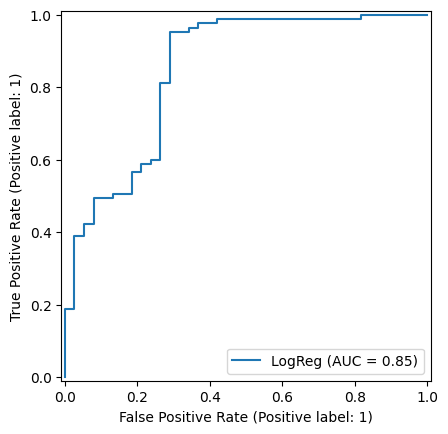

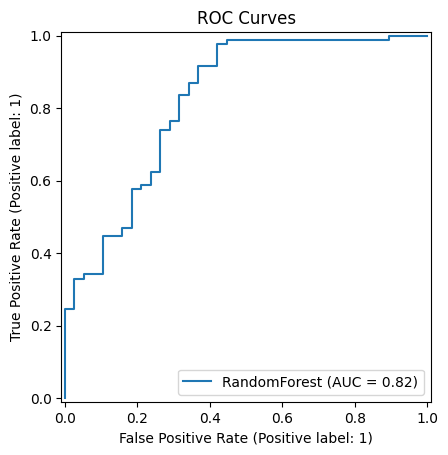

In [22]:
# Quick CV sanity check (ROC AUC)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring="roc_auc", n_jobs=-1)
print("\nRF 5-fold ROC AUC (mean ± std):", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


# ROC curves

plt.figure()
RocCurveDisplay.from_predictions(y_test, proba_lr, name="LogReg")
RocCurveDisplay.from_predictions(y_test, proba_rf, name="RandomForest")
plt.title("ROC Curves")
plt.show()


In [23]:
# Feature importance (RF)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 features by importance:\n", importances.head(15))


# Persist artifacts

joblib.dump(logreg, "/content/model_logreg_pipeline.joblib")
joblib.dump(rf, "/content/model_random_forest.joblib")
print("\nSaved: /content/model_logreg_pipeline.joblib, /content/model_random_forest.joblib")




Top 15 features by importance:
 Credit_History             0.166812
ApplicantIncome            0.134361
LoanAmount                 0.128236
CoapplicantIncome          0.083919
Property_Area_Semiurban    0.081719
Loan_Amount_Term           0.069298
Gender                     0.051079
Dependents_3+              0.049239
Education                  0.044903
Married                    0.041349
Self_Employed              0.040163
Dependents_1               0.038979
Dependents_2               0.036353
Property_Area_Urban        0.033592
Loan_ID_LP002305           0.000000
dtype: float64

Saved: /content/model_logreg_pipeline.joblib, /content/model_random_forest.joblib


In [11]:
!pip -q install streamlit pyngrok joblib

# Kill previous ngrok/streamlit (safe no-ops if not running)
!pkill -f ngrok || true
!pkill -f streamlit || true


^C
^C


In [13]:
%%writefile /content/app.py
import joblib
import numpy as np
import pandas as pd
import streamlit as st


MODEL_PATH = "/content/model_random_forest.joblib"
mdl = joblib.load(MODEL_PATH)

def get_feature_cols(model):
    if hasattr(model, "feature_names_in_"):
        return list(model.feature_names_in_)
    if hasattr(model, "named_steps"):
        for _, step in model.named_steps.items():
            if hasattr(step, "feature_names_in_"):
                return list(step.feature_names_in_)
    return []

FEATURE_COLS = get_feature_cols(mdl)
if not FEATURE_COLS:
    st.error("Model is missing feature_names_in_. Refit the model using a pandas DataFrame.")
    st.stop()

# Top features
TOP_FEATURES = [
    "Credit_History",
    "ApplicantIncome",
    "LoanAmount",
    "CoapplicantIncome",
    "Property_Area_Semiurban",
    "Loan_Amount_Term",
    "Gender",
    "Dependents_3+",
    "Education",
    "Married",
    "Self_Employed",
    "Dependents_1",
    "Dependents_2",
    "Property_Area_Urban"

]

# UI
st.set_page_config(page_title="Loan Approval (Top Features)", page_icon="💳", layout="centered")
st.title("💳 Loan Approval Predictor — Top Features")
st.caption("Inputs limited to the strongest predictors. Other model features default to 0.")

with st.form("loan_form"):
    col1, col2 = st.columns(2)

    with col1:
        credit_history = st.selectbox("Credit_History", [1.0, 0.0], index=0)
        applicant_income = st.number_input("ApplicantIncome", min_value=0.0, step=100.0)
        loan_amount = st.number_input("LoanAmount", min_value=0.0, step=1.0)
        coapplicant_income = st.number_input("CoapplicantIncome", min_value=0.0, step=100.0)
        loan_amount_term = st.number_input("Loan_Amount_Term (months)", min_value=0.0, step=6.0)

    with col2:
        gender = st.selectbox("Gender", ["Male", "Female"])
        married = st.selectbox("Married", ["Yes", "No"])
        education = st.selectbox("Education", ["Graduate", "Not Graduate"])
        self_employed = st.selectbox("Self_Employed", ["No", "Yes"])
        dependents = st.selectbox("Dependents", ["0", "1", "2", "3+"])

    property_area = st.selectbox("Property_Area", ["Rural", "Semiurban", "Urban"], index=1)
    submitted = st.form_submit_button("Predict")

# Build aligned feature vector from top-features UI
def build_row_from_inputs():
    # Start with zeros for ALL model features
    row = pd.Series(0, index=FEATURE_COLS, dtype="float64")

    # Direct numeric features
    if "Credit_History" in row.index:        row["Credit_History"] = float(credit_history)
    if "ApplicantIncome" in row.index:       row["ApplicantIncome"] = float(applicant_income)
    if "LoanAmount" in row.index:            row["LoanAmount"] = float(loan_amount)
    if "CoapplicantIncome" in row.index:     row["CoapplicantIncome"] = float(coapplicant_income)
    if "Loan_Amount_Term" in row.index:      row["Loan_Amount_Term"] = float(loan_amount_term)

    # Binary maps
    if "Gender" in row.index:
        row["Gender"] = 1.0 if gender in ["Male", "M"] else 0.0
    if "Married" in row.index:
        row["Married"] = 1.0 if married == "Yes" else 0.0
    if "Education" in row.index:
        row["Education"] = 1.0 if education == "Graduate" else 0.0
    if "Self_Employed" in row.index:
        row["Self_Employed"] = 1.0 if self_employed == "Yes" else 0.0

    # Dependents dummies: base = "0"
    # Expected columns from your training: Dependents_1, Dependents_2, Dependents_3+
    dep_map = {"1": "Dependents_1", "2": "Dependents_2", "3+": "Dependents_3+"}
    if dependents in dep_map and dep_map[dependents] in row.index:
        row[dep_map[dependents]] = 1.0
    # else "0" case: keep all zeros

    # Property_Area dummies: base = "Rural"
    # Expected columns: Property_Area_Semiurban, Property_Area_Urban
    if property_area == "Semiurban" and "Property_Area_Semiurban" in row.index:
        row["Property_Area_Semiurban"] = 1.0
    elif property_area == "Urban" and "Property_Area_Urban" in row.index:
        row["Property_Area_Urban"] = 1.0
    # else Rural: keep zeros

    return pd.DataFrame([row])

# Predict
if submitted:
    try:
        X = build_row_from_inputs()
        # predict_proba if available
        if hasattr(mdl, "predict_proba"):
            proba = float(mdl.predict_proba(X)[:, 1][0])
        else:
            score = float(getattr(mdl, "decision_function", mdl.predict)(X)[0])
            proba = 1 / (1 + np.exp(-score)) if not (0 <= score <= 1) else score

        label = "Approved" if proba >= 0.5 else "Not Approved"
        st.subheader(label)
        st.metric("Approval Probability", f"{proba:.3f}")

        with st.expander("Debug: model feature vector"):
            st.write(X.T.rename(columns={0: "value"}))

        # Show top features for transparency if model is RF
        if hasattr(mdl, "feature_importances_"):
            st.subheader("Top Features by Importance")
            importances = pd.Series(mdl.feature_importances_, index=FEATURE_COLS)
            top = importances.sort_values(ascending=False).head(15)
            st.bar_chart(top.sort_values())  # Streamlit bar chart (horizontal via sort)

    except Exception as e:
        st.error(f"Prediction failed: {e}")


Overwriting /content/app.py


In [24]:

# Launch Streamlit + ngrok (Colab)

!pip -q install streamlit pyngrok joblib requests >/dev/null

import os, time, threading, requests, sys
from pyngrok import ngrok


assert os.path.exists("/content/app.py"), "app.py not found at /content/app.py"

!pkill -f streamlit || true
!pkill -f ngrok || true

# ngrok auth
NGROK_AUTH_TOKEN = "33f8FfDyBPdj8xZ1ki3L73bPYDi_7W2nJ3bv5AD5tr7VAHSfa"
os.system(f"ngrok config add-authtoken {NGROK_AUTH_TOKEN}")

# Start Streamlit (0.0.0.0:8501)
def run_streamlit():
    cmd = (
        "streamlit run /content/app.py "
        "--server.address 0.0.0.0 "
        "--server.port 8501 "
        "--server.headless true "
        "--server.enableCORS false "
        "--server.enableXsrfProtection false "
        "--browser.gatherUsageStats false "
        "--server.fileWatcherType none"
    )
    os.system(cmd)

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

# check
def wait_for_streamlit(timeout=60):
    url = "http://localhost:8501/_stcore/health"
    start = time.time()
    while time.time() - start < timeout:
        try:
            r = requests.get(url, timeout=2)
            if r.status_code == 200:
                return True
        except Exception:
            pass
        time.sleep(1)
    return False

print("⏳ Waiting for Streamlit to start...")
if not wait_for_streamlit():
    print("Streamlit did not start within timeout. Check the app logs.", file=sys.stderr)
else:
    public_url = ngrok.connect(8501, "http")
    print("Your Streamlit app is live:", public_url)


^C
^C
⏳ Waiting for Streamlit to start...
Your Streamlit app is live: NgrokTunnel: "https://pseudobrotherly-acritical-valeria.ngrok-free.dev" -> "http://localhost:8501"
